In [3]:
!pip -q install vaderSentiment

[info] Harvesting DOC API …
[probe] Range: 2010-01-01 → 2025-08-27 | initial windows: 188 (month)
[warn] Doc API failed for 2010-01-01 → 2010-01-31: HTTPSConnectionPool(host='api.gdeltproject.org', port=443): Max retries exceeded with url: /api/v2/doc/doc?query=%28turkey+OR+%22t%C3%BCrkiye%22+OR+turkiye%29&mode=ArtList&format=json&maxrecords=250&sort=DateAsc&startdatetime=20100101000000&enddatetime=20100131235959&sourcelang=english (Caused by ResponseError('too many 429 error responses'))
[-- ] 2010-01-01 → 2010-01-31 |   0 rows | 31d
[warn] Doc API failed for 2010-02-01 → 2010-02-28: HTTPSConnectionPool(host='api.gdeltproject.org', port=443): Max retries exceeded with url: /api/v2/doc/doc?query=%28turkey+OR+%22t%C3%BCrkiye%22+OR+turkiye%29&mode=ArtList&format=json&maxrecords=250&sort=DateAsc&startdatetime=20100201000000&enddatetime=20100228235959&sourcelang=english (Caused by ResponseError('too many 429 error responses'))
[-- ] 2010-02-01 → 2010-02-28 |   0 rows | 28d
[warn] Doc API f

,url,title,seendate,domain,sourcecountry,language,socialimage,year,region,tone_vader
199245,http://www.aydinses.com/guvenlik/ihbar-dogru-c...,"Türkiye , haber , haberleri , gaziosmanşa , ey...",2019-05-14 13:45:00+00:00,aydinses.com,Turkey,Turkish,http://www.aydinses.com/images/haberler/2019/0...,2019,Non-NATO / Global South,0.0
199246,http://www.aydinses.com/guvenlik/goruntulu-dri...,"Türkiye , haber , haberleri , gaziosmanşa , ey...",2019-05-14 13:45:00+00:00,aydinses.com,Turkey,Turkish,http://www.aydinses.com/images/haberler/no_hea...,2019,Non-NATO / Global South,0.0
199247,http://www.aydinses.com/politika/ak-parti-li-m...,"Türkiye , haber , haberleri , gaziosmanşa , ey...",2019-05-14 13:45:00+00:00,aydinses.com,Turkey,Turkish,http://www.aydinses.com/images/haberler/2019/0...,2019,Non-NATO / Global South,0.0
199248,https://sputnik-georgia.ru/tourism/20190514/24...,Насколько выросло число туристов в Грузии,2019-05-14 13:45:00+00:00,sputnik-georgia.ru,Russia,Russian,https://cdn1.img.sputnik-georgia.com/images/24...,2019,Non-NATO / Global South,0.0
199249,https://www.haberartiturk.com/ercan-gun-hakkin...,Ercan Gün Hakkında 7 Şubat Mit Kumpası İddiana...,2019-05-14 13:45:00+00:00,haberartiturk.com,Turkey,Turkish,https://www.haberartiturk.com/d/news/113076.jpg,2019,Non-NATO / Global South,0.0


[save] articles → gdelt_turkey_articles_2010_present.csv
[info] No data for NATO.


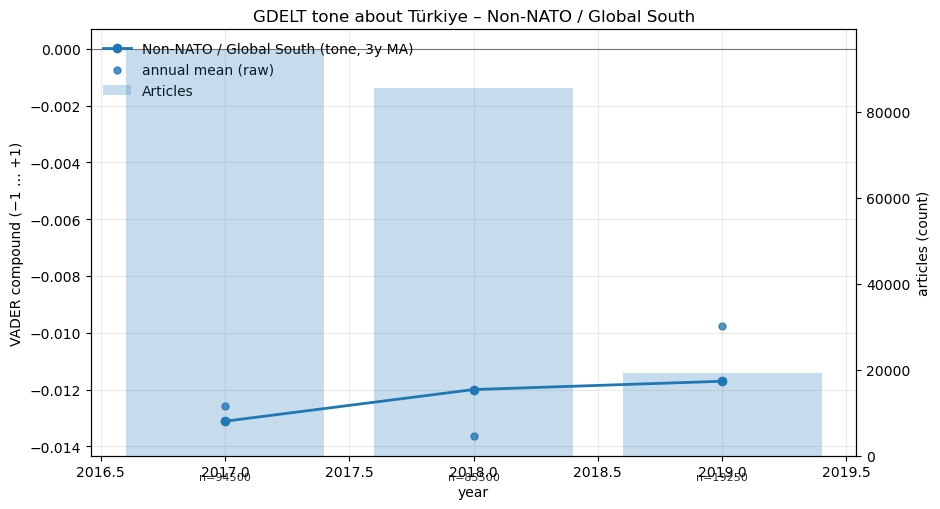


[pivot] Year × Region tone (mean):


region,Non-NATO / Global South
year,
2017,-0.013
2018,-0.014
2019,-0.010



Top NATO sources by volume:


,articles
domain,



Top Non-NATO / Global South sources by volume:


,articles
domain,
haberler.com,5905
aydinses.com,5164
haberx.com,2512
ziarelive.ro,2021
milliyet.com.tr,1615
yeniakit.com.tr,1529
mynet.com,1513
yenisafak.com,1511
memleket.com.tr,1466


[save] Year×Region aggregates → gdelt_turkey_sentiment_by_year_region.csv


In [1]:
# === Mechanism 4 – Recognition via GDELT DOC (one-cell full pipeline) ==========================
# Adaptive pagination (beyond 250/req), robust requests, progress/ETA, cleaning, sentiment (VADER),
# NATO vs Non-NATO/Global South bucketing, yearly plots with smoothing, and CSV outputs.

# -----------------------------
# Config (edit freely)
# -----------------------------
QUERY          = '(turkey OR "türkiye" OR turkiye)'
SOURCE_LANG    = 'english'                     # '' for all languages
START_DATE     = '2010-01-01'
END_DATE       = None                          # None = today
BASE_GRANULARITY = 'month'                     # 'month' | 'week' | 'day' (start coarse; auto-splits)
MIN_GRANULARITY_DAYS = 1                       # stop splitting when window <= this many days
RATE_LIMIT_S   = 0.35                          # polite pause between requests
MAX_RETRIES    = 3
TIMEOUT_S      = 30

# CSV outputs
SAVE_ARTICLES_CSV = "gdelt_turkey_articles_2010_present.csv"
SAVE_AGG_CSV      = "gdelt_turkey_sentiment_by_year_region.csv"

# Plot options
SMOOTH_WIN_YEARS  = 3                          # moving average for tone line (visual only)

# ============================= DO NOT EDIT BELOW UNLESS YOU WANT TO TWEAK ======================
import re, json, math, time, warnings
from datetime import datetime, timedelta, date
from calendar import monthrange
from typing import List, Tuple

import numpy as np
import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry
import matplotlib.pyplot as plt

# --- Optional: VADER sentiment -----------------------------------------------------------------
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    _vader = SentimentIntensityAnalyzer()
except Exception:
    _vader = None
    warnings.warn("[warn] vaderSentiment not available. Sentiment will be NaN.", UserWarning)

def _vader_sent(text):
    if _vader is None or not isinstance(text, str) or not text.strip():
        return np.nan
    try:
        return float(_vader.polarity_scores(text)['compound'])
    except Exception:
        return np.nan

# --- NATO region mapping (prefer sourcecountry; fall back to domain heuristic) ------------------
NATO_ISO2 = {
    "US","CA","GB","UK","DE","FR","IT","ES","PT","BE","NL","LU","DK","NO","IS",
    "TR","GR","PL","CZ","SK","HU","RO","BG","SI","HR","AL","ME","MK","LT","LV","EE"
}

def region_from_sourcecountry(code):
    if not isinstance(code, str) or not code:
        return "Non-NATO / Global South"
    return "NATO" if code.upper() in NATO_ISO2 else "Non-NATO / Global South"

def region_from_domain(domain):
    if not isinstance(domain, str) or not domain:
        return "Non-NATO / Global South"
    d = domain.lower()
    # Handle well-known NATO media with .com TLD:
    if any(x in d for x in ["bbc.", "ft.", "reuters.", "apnews.", "politico.", "guardian.", "nytimes.", "washingtonpost."]):
        return "NATO"
    m = re.search(r"\.([a-z]{2})(?:$|/)", d)
    if m:
        cc = m.group(1)
        return "NATO" if cc.upper() in NATO_ISO2 else "Non-NATO / Global South"
    return "Non-NATO / Global South"

# --- Robust requests session -------------------------------------------------------------------
def _session_with_retries():
    s = requests.Session()
    retries = Retry(total=5, backoff_factor=0.5, status_forcelist=[429,500,502,503,504])
    s.mount("https://", HTTPAdapter(max_retries=retries))
    s.mount("http://",  HTTPAdapter(max_retries=retries))
    s.headers.update({"User-Agent": "gdelt-doc-recognition/1.1"})
    return s

# --- DOC API helpers ----------------------------------------------------------------------------
DOC_URL = "https://api.gdeltproject.org/api/v2/doc/doc"

def _fmt_dt(dt):
    return dt.strftime("%Y%m%d%H%M%S")

def _doc_params(query, start_dt, end_dt, lang):
    p = {
        "query": query,
        "mode": "ArtList",
        "format": "json",
        "maxrecords": "250",
        "sort": "DateAsc",
        "startdatetime": _fmt_dt(start_dt),
        "enddatetime": _fmt_dt(end_dt),
    }
    if lang:
        p["sourcelang"] = lang
    return p

def fetch_window(session, query, start_dt, end_dt, lang):
    """Fetch one window; returns DataFrame or empty on failure."""
    params = _doc_params(query, start_dt, end_dt, lang)
    for attempt in range(1, MAX_RETRIES+1):
        try:
            r = session.get(DOC_URL, params=params, timeout=TIMEOUT_S)
            if r.status_code != 200 or not r.text.strip():
                raise ValueError(f"HTTP {r.status_code} empty/invalid body")
            try:
                js = r.json()
            except Exception:
                cleaned = re.sub(r"[\x00-\x1F\x7F]", " ", r.text)
                js = json.loads(cleaned)
            rows = js.get("articles", [])
            if not isinstance(rows, list) or not rows:
                return pd.DataFrame()
            df = pd.DataFrame(rows)
            keep = [c for c in [
                "url","title","seendate","domain","sourcecountry","language","sourceurl","socialimage","themes","tone"
            ] if c in df.columns]
            return df[keep].copy() if keep else df
        except Exception as e:
            if attempt == MAX_RETRIES:
                print(f"[warn] Doc API failed for {start_dt:%Y-%m-%d} → {end_dt:%Y-%m-%d}: {e}")
                return pd.DataFrame()
            time.sleep(0.6 + attempt*0.4)
    return pd.DataFrame()

# --- Window creation & splitting ---------------------------------------------------------------
def iter_initial_windows(start_dt, end_dt, mode='month'):
    out = []
    cur = start_dt.replace(hour=0, minute=0, second=0, microsecond=0)
    end_dt = end_dt.replace(microsecond=0)
    if mode == 'month':
        while cur <= end_dt:
            last_day = monthrange(cur.year, cur.month)[1]
            win_end = datetime(cur.year, cur.month, last_day, 23, 59, 59)
            if win_end > end_dt:
                win_end = end_dt
            out.append((cur, win_end))
            # next first-of-month
            if cur.month == 12:
                cur = datetime(cur.year + 1, 1, 1)
            else:
                cur = datetime(cur.year, cur.month + 1, 1)
    elif mode == 'week':
        while cur <= end_dt:
            win_end = min(cur + timedelta(days=6, hours=23, minutes=59, seconds=59), end_dt)
            out.append((cur, win_end))
            cur = win_end + timedelta(seconds=1)
    else:  # day
        while cur <= end_dt:
            win_end = min(cur + timedelta(hours=23, minutes=59, seconds=59), end_dt)
            out.append((cur, win_end))
            cur = win_end + timedelta(seconds=1)
    return out

def split_window(start_dt, end_dt):
    span = end_dt - start_dt
    if span <= timedelta(days=1):
        mid = start_dt + span/2
        return [(start_dt, mid - timedelta(seconds=1)), (mid, end_dt)]
    mid = start_dt + span/2
    return [(start_dt, mid - timedelta(seconds=1)), (mid, end_dt)]

# --- Adaptive harvest (auto-splits when window saturates at 250 rows) --------------------------
def harvest_docs_adaptive(query, start_date, end_date, lang=SOURCE_LANG,
                          min_days=MIN_GRANULARITY_DAYS, base_granularity=BASE_GRANULARITY,
                          rate_limit_s=RATE_LIMIT_S):
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    if end_date is None:
        end_date = datetime.utcnow().strftime("%Y-%m-%d")
    end_dt   = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(hours=23, minutes=59, seconds=59)

    session = _session_with_retries()
    todo = iter_initial_windows(start_dt, end_dt, base_granularity)
    all_parts, done, total = [], 0, len(todo)
    t0, rows_so_far = time.time(), 0

    print("[info] Harvesting DOC API …")
    print(f"[probe] Range: {start_dt:%Y-%m-%d} → {end_dt:%Y-%m-%d} | initial windows: {total} ({base_granularity})")

    while todo:
        win_start, win_end = todo.pop(0)
        if win_start > win_end:
            continue

        df = fetch_window(session, query, win_start, win_end, lang)
        rows = len(df)
        rows_so_far += rows
        ddays = (win_end - win_start).days + 1
        saturated = (rows >= 250)

        if rows > 0:
            print(f"[ok ] {win_start:%Y-%m-%d} → {win_end:%Y-%m-%d} | {rows:3d} rows | {ddays}d {'SATURATED' if saturated else ''}")
        else:
            print(f"[-- ] {win_start:%Y-%m-%d} → {win_end:%Y-%m-%d} |   0 rows | {ddays}d")

        if saturated and ddays > min_days:
            # split and re-queue the halves at the front to drill down immediately
            todo = split_window(win_start, win_end) + todo
        else:
            if rows:
                all_parts.append(df)

        done += 1
        total = done + len(todo)

        # heartbeat with ETA every 10 windows (and at the end)
        if done % 10 == 0 or not todo:
            elapsed = time.time() - t0
            rate = done / elapsed if elapsed > 0 else float('inf')
            eta = (len(todo) / rate) if rate and np.isfinite(rate) else float('inf')
            print(f"  └ progress: {done}/{total} windows | rows {rows_so_far} | elapsed {elapsed/60:.1f} min | ETA ~{(eta/60):.1f} min | queue {len(todo)}")

        time.sleep(rate_limit_s)

    out = pd.concat(all_parts, ignore_index=True) if all_parts else pd.DataFrame()
    print(f"[done] Harvest complete in {(time.time()-t0)/60:.1f} min. Rows: {len(out)}")
    return out

# --- Timelinetone fallback (overall tone only) --------------------------------------------------
TIMELINE_TONE = "https://api.gdeltproject.org/api/v2/doc/timelinetone"

def timelinetone_fallback_plot(query, start_date, end_date, lang='english', bucket='7d'):
    if end_date is None:
        end_date = datetime.utcnow().strftime("%Y-%m-%d")
    params = {
        "query": query, "sourcelang": lang, "format": "json", "timebucket": bucket,
        "startdatetime": datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y%m%d000000"),
        "enddatetime":   datetime.strptime(end_date,   "%Y-%m-%d").strftime("%Y%m%d235959"),
    }
    print(f"[fallback] timelinetone {start_date} → {end_date} …")
    s = _session_with_retries()
    r = s.get(TIMELINE_TONE, params=params, timeout=30)
    if r.status_code != 200 or not r.text.strip():
        print("[fallback] timelinetone failed; nothing to plot.")
        return
    try:
        js = r.json()
    except Exception:
        js = json.loads(re.sub(r"[\x00-\x1F\x7F]", " ", r.text))
    tl = js.get("timeline", [])
    if not tl:
        print("[fallback] timelinetone returned no points.")
        return
    df = pd.DataFrame(tl)
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"])
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df["datetime"], df["tone"], linewidth=1.8)
    ax.set_title("GDELT timelinetone – Türkiye (overall)")
    ax.set_xlabel("time"); ax.set_ylabel("tone"); ax.grid(alpha=0.25)
    fig.tight_layout(); plt.show()
    display(df.tail(10))

# --- Run the harvest ----------------------------------------------------------------------------
END_DATE_STR = END_DATE if END_DATE is not None else datetime.utcnow().strftime("%Y-%m-%d")
docs = harvest_docs_adaptive(
    QUERY, START_DATE, END_DATE_STR,
    lang=SOURCE_LANG,
    min_days=MIN_GRANULARITY_DAYS,
    base_granularity=BASE_GRANULARITY,
    rate_limit_s=RATE_LIMIT_S
)

print(f"\n[info] Downloaded: {len(docs)} rows (pre de-dup).")

# --- Clean & normalize -------------------------------------------------------------------------
if docs.empty:
    print("[info] No DOC rows harvested; invoking fallback plot so you can verify the pipeline.")
    timelinetone_fallback_plot(QUERY, START_DATE, END_DATE_STR, SOURCE_LANG)
else:
    # Parse seendate into datetime & year (handles 2024-08-26T..., 2024-08-26, 20240826T...)
    def _parse_dt(x):
        if not isinstance(x, str) or not x.strip():
            return pd.NaT
        # quickest robust parse
        try:
            if "T" in x or "-" in x:
                return pd.to_datetime(x, errors="coerce", utc=False)
            return pd.to_datetime(x, format="%Y%m%d%H%M%S", errors="coerce", utc=False)
        except Exception:
            return pd.NaT

    if "seendate" in docs.columns:
        docs["seendate"] = docs["seendate"].apply(_parse_dt)
        docs["year"] = docs["seendate"].dt.year
    else:
        docs["year"] = np.nan

    # De-dup on URL (and title if URL is missing)
    before = len(docs)
    keycols = ["url"] if "url" in docs.columns else []
    if "title" in docs.columns:
        keycols.append("title")
    docs = docs.drop_duplicates(subset=keycols, keep="first")
    print(f"[info] De-duplicated: {before} → {len(docs)} rows.")

    # Region bucketing (prefer sourcecountry if present)
    if "sourcecountry" in docs.columns and docs["sourcecountry"].notna().any():
        docs["region"] = docs["sourcecountry"].apply(region_from_sourcecountry)
    else:
        docs["region"] = docs.get("domain", "").apply(region_from_domain)

    # Sentiment on titles (extend to descriptions if you add them)
    if "title" in docs.columns:
        docs["tone_vader"] = docs["title"].fillna("").apply(_vader_sent)
    else:
        docs["tone_vader"] = np.nan

    # Quick peek to ensure rows look sensible
    print("\n[sample] Last 5 rows after cleaning:")
    display(docs.tail(5))

    # Save raw
    docs.to_csv(SAVE_ARTICLES_CSV, index=False)
    print(f"[save] articles → {SAVE_ARTICLES_CSV}")

    # --- Aggregate & plot (year × region) ------------------------------------------------------
    valid = docs.dropna(subset=["year"])
    if valid.empty:
        print("[info] No parseable years; showing fallback timeline.")
        timelinetone_fallback_plot(QUERY, START_DATE, END_DATE_STR, SOURCE_LANG)
    else:
        valid["year"] = valid["year"].astype(int)

        grp = (valid.groupby(["year","region"], as_index=False)
                     .agg(mean_tone=("tone_vader","mean"),
                          n_articles=("url","size") if "url" in valid.columns else ("title","size")))

        # keep the two buckets for clarity
        keep = ["NATO","Non-NATO / Global South"]
        grp = grp[grp["region"].isin(keep)].copy()

        # smoothing helper (visual only)
        def _smooth(y, win=SMOOTH_WIN_YEARS):
            if win <= 1 or len(y) == 0:
                return np.asarray(y)
            return pd.Series(y).rolling(win, center=True, min_periods=1).mean().to_numpy()

        # plot per region
        for region in keep:
            sub = grp[grp["region"] == region].sort_values("year")
            if sub.empty:
                print(f"[info] No data for {region}.")
                continue

            fig, ax = plt.subplots(figsize=(9.5, 5.2))
            ax.plot(sub["year"], _smooth(sub["mean_tone"], SMOOTH_WIN_YEARS),
                    marker="o", linewidth=2, label=f"{region} (tone, {SMOOTH_WIN_YEARS}y MA)")
            ax.scatter(sub["year"], sub["mean_tone"], s=25, alpha=0.8, label="annual mean (raw)")
            ax.axhline(0, color="black", lw=0.8, alpha=0.5)

            # annotate n
            for x, n in zip(sub["year"], sub["n_articles"]):
                ax.annotate(f"n={int(n)}", (x, ax.get_ylim()[0]), xytext=(0, -12),
                            textcoords="offset points", ha="center", va="top", fontsize=8, alpha=0.85)

            ax2 = ax.twinx()
            ax2.bar(sub["year"], sub["n_articles"], alpha=0.25, width=0.8, label="Articles", align="center")

            ax.set_title(f"GDELT tone about Türkiye – {region}")
            ax.set_xlabel("year")
            ax.set_ylabel("VADER compound (−1 … +1)")
            ax2.set_ylabel("articles (count)")

            h1, l1 = ax.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax.legend(h1+h2, l1+l2, loc="upper left", frameon=False)
            ax.grid(alpha=0.25)
            fig.tight_layout()
            plt.show()

        # wide pivot table to eyeball numbers
        print("\n[pivot] Year × Region tone (mean):")
        display(grp.pivot_table(index="year", columns="region", values="mean_tone").round(3).fillna(""))

        # top sources by volume
        if "domain" in valid.columns:
            print("\nTop NATO sources by volume:")
            display(valid[valid["region"]=="NATO"].groupby("domain").size()
                    .sort_values(ascending=False).head(15).to_frame("articles"))
            print("\nTop Non-NATO / Global South sources by volume:")
            display(valid[valid["region"]=="Non-NATO / Global South"].groupby("domain").size()
                    .sort_values(ascending=False).head(15).to_frame("articles"))

        # save aggregates
        grp.to_csv(SAVE_AGG_CSV, index=False)
        print(f"[save] Year×Region aggregates → {SAVE_AGG_CSV}")
